Here we are going to extract the first 100000 tweets to understand how the Kathy Griffin story initially spread.

In [57]:
import pandas as pd
#import gensim
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('max_colwidth',1000)
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk


In [8]:
final_data = pd.read_pickle("datanobots.pkl")
first100k = final_data.head(100000)
first100k = first100k.reset_index()

In [13]:
#removing some tweets that came before the story was released
first100k = first100k[first100k.created > pd.Timestamp('2017-05-30 13:30:00')]


(array([ 736479.58333333,  736479.625     ,  736479.66666667,
         736479.70833333,  736479.75      ,  736479.79166667]),
 <a list of 6 Text xticklabel objects>)

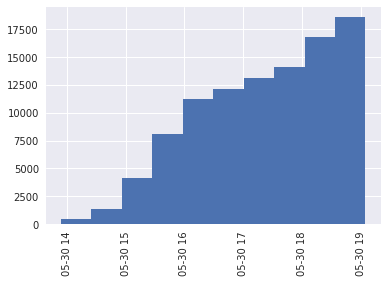

In [12]:
first100k.created.hist()
plt.xticks(rotation=90)

It takes a bit of time for people to start tweeting a lot about the story.

Now lets look at what hashtags are being used.

In [15]:
def extract_hashtags(row):
    hashtags = []
    if row["hashtags"]:
        for x in row["hashtags"]:
            hashtags.append(x["text"])
        return hashtags
    else:
        return 0

In [16]:
hashtags = []
for x in first100k.entities.values:
    if x["hashtags"]:
        for y in x["hashtags"]:
            hashtags.append(y["text"])
hashtags = [x.lower() for x in hashtags]

In [17]:
Counter(hashtags).most_common(20)

[('kathygriffin', 1326),
 ('maga', 653),
 ('trump', 484),
 ('theresistance', 409),
 ('retweet', 400),
 ('lockherup', 320),
 ('periscope', 269),
 ('tcot', 268),
 ('leftistsarenuts', 202),
 ('fakenews', 161),
 ('dumbshit', 127),
 ('whitehousesongs', 118),
 ('tuesdaymotivation', 118),
 ('cnn', 106),
 ('مسابقه_الوليد_شفاه_الله_4', 84),
 ('kathy', 81),
 ('stopthescalpings', 81),
 ('pureevil', 74),
 ('kathygriffinhatecrime', 67),
 ('kekistan', 66)]

Most hashtags seems to be conservative slanted but there are some liberal ones like theresistance in here

Now lets look at urls

In [18]:
urls = []
for x in first100k.entities.values:
    if x["urls"]:
        urls.append(x["urls"][0]["expanded_url"])

In [19]:
Counter(urls).most_common(20)

[('http://www.dailywire.com/news/16998/disgusting-kathy-griffin-holds-trumps-bloody-hank-berrien',
  4564),
 ('http://www.tmz.com/2017/05/30/kathy-griffin-beheads-donald-trump-photo-tyler-shields/',
  1973),
 ('http://breaking911.com/kathy-griffin-beheads-president-trump-shocking-new-photos/',
  707),
 ('https://twitter.com/Breaking911/status/869618179391336450', 537),
 ('http://fb.me/4D5JEP5rZ', 388),
 ('http://www.breitbart.com/big-hollywood/2017/05/30/kathy-griffin-beheads-donald-trump-shock-bloody-photo/',
  321),
 ('http://bit.ly/2siT0kc', 309),
 ('https://twitter.com/polnewsforever/status/869621326650257408', 307),
 ('http://dlvr.it/PH38yr', 291),
 ('http://www.foxnews.com/entertainment/2017/05/30/kathy-griffin-holds-bloodied-trump-mask-in-photo-shoot-with-tyler-shields.html',
  286),
 ('https://twitter.com/TheDailyEdge/status/869422284573900800', 283),
 ('http://www.thegatewaypundit.com/2017/05/disgusting-washed-comedian-kathy-griffin-beheads-trump-laughs/',
  200),
 ('http://bi

Interesting..the daily wire is the most retweeted article even though it was not the one to break the story (came about 1.5 hours after the original TMZ story). This website is highly conservative suggesting conservatives were propping this story up.

Now we are going to look at  identifing the political affliation and where these people are retweeting from. I identified  conservatives and liberals with 100k followers, news sites, and the two most retweeted links: dailywire and TMZ. The purpose of this is to get a better understanding of how the story spread. These tweets will be graphed with this information in a different notebook.

I determined who were conservatives and who were liberals based on hashtags they are using and their user description


The code for this, and what signifies liberal or conservative was made with a lot of trial and error

In [22]:
#Here creating certain masks to search user descriptions for these signifying words
#One would expect "liberal" in the liberal mask. However, when I looked at that, most people with "liberal" in their
#description were using it like "bashing liberal beliefs" or something like that.
conservative_mask_desc = ("|").join(["maga", "trump", "tcot", "fakenews", "covfefe", "sethrich", "cnnisisis", "hannity", "trumptrain",
                "lockherup", "kathygriffinhatecrime", "tucker", "arrestkathygriffin", "apologynotaccepted",
                "trumpusa", "infowars", "isis", "leftistsarenuts", "alexjonesshow", "tucker", "conservative", "republican", "patriot", "prolife", "pro-life"])
liberal_mask_desc = ("|").join(["antifa", "theresistance", "resistance", "#p2", "blacklivesmatter", "democrat", "pro choice", "progessive"])

In [23]:
conservative_mask_desc = first100k.user_desc.str.contains(conservative_mask_desc, case=False)
liberal_mask_desc =first100k.user_desc.str.contains(liberal_mask_desc, case=False)

In [24]:
def check_url(row):
    try:
        if row["urls"][0]:
            if row["urls"][0]["expanded_url"] =="http://www.tmz.com/2017/05/30/kathy-griffin-beheads-donald-trump-photo-tyler-shields":
                return 1
                
            elif row["urls"][0]["expanded_url"] == "http://www.tmz.com/2017/05/30/kathy-griffin-beheads-donald-trump-photo-tyler-shields/":
                return 1
                
            elif row["urls"][0]["expanded_url"] == "http://www.dailywire.com/news/16998/disgusting-kathy-griffin-holds-trumps-bloody-hank-berrien":
                return 2
            #this facebook article also leads to the dailywire 
            elif row["urls"][0]["expanded_url"] == "http://fb.me/4D5JEP5rZ":
                return 2
        else:
            return 0
    except:
        return 0

In [27]:
#the order in which you run this code changes the results...slightly...but not in any real meaningful way
first100k["type"] = 0
first100k["type"] = first100k.entities.apply(lambda x: check_url(x))
first100k.loc[first100k.user_desc.str.contains("mashable|cbsnews|news|msncbc|dailybeast|cnn|foxnews|@foxnews|cbs|nbc|abc|buzzfeed|yahoo|nymag|tmz|breitbart|dailywire", case=False), "type"] = 3

first100k.loc[first100k.text.str.contains("tmz|@tmz|https://t.co/rzXjz380Ax|https://t.co/RLzHGykKhK", case=False), "type"] = 1
#first100k.type.value_counts()

first100k.loc[first100k.text.str.contains("dailywire|@dailywire", case=False), "type"] = 2
#first100k.loc[first100k.entities['urls'][0]["expanded_url"] == "http://fb.me/4D5JEP5rZ"] = 2
first100k.loc[(first100k.followers_counts <  100000) & (first100k.type ==3) , "type"] = 0

first100k.loc[(first100k.followers_counts >  100000) & conservative_mask_desc , "type"] = 4
first100k.loc[(first100k.followers_counts >  100000) & liberal_mask_desc , "type"] = 5

#This line is to ensure that the news sites we are getting are probably actually news sites and not just people putting
#news in their description 
first100k.loc[(first100k.followers_counts <  50000) & (first100k.type == 3) , "type"] = 0


In [68]:
#0 --normal tweet, 2 -- dailywire reference, 3 -- news references,
#4 -- conservative heavy hitters, 5 -- liberal heavy hitters
first100k.type.value_counts()


0.0    77002
2.0     4879
1.0     2742
4.0      116
3.0       96
5.0        8
Name: type, dtype: int64

This is intriguing. Either it is much easier to identify conservatives or just not that many liberal people were talkng about this story.

Let's look at the polarity of tweets too...that will be useful for graphing

In [30]:
ab = SentimentIntensityAnalyzer()
def polarity(row):
    vs = ab.polarity_scores(row)
    return vs["compound"]

Tweets tend to be negative which is unsuprising given the heavy conservative element and subject matter

In [31]:
first100k["polarity"] = first100k.text.apply(lambda x: polarity(x))
first100k.polarity.mean()

-0.18766900338006759

Now lets move on to some topic modelling to see what people are talking about. I initially ran topic modelling with both TFIDF and count vectorizer with LDA and LMF with a variety of ngrams and components/topics. I will only show a couple here.

In [46]:
def get_wordnet_pos(row):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""
    treebank_tag = pos_tag([row])
    if treebank_tag[0][1].startswith('J'):
        return wordnet.ADJ
        print(treebank_tag)
    elif treebank_tag[0][1].startswith('V'):
        return wordnet.VERB

    elif treebank_tag[0][1].startswith('N'):
        return wordnet.NOUN

    elif treebank_tag[0][1].startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [59]:
count_vectorizer = CountVectorizer(ngram_range=((1,1)),  
                                   stop_words=stopwords, 
                                   analyzer = "word",
                                   tokenizer = text_cleaner_and_stemmer,
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   min_df=25, max_df=.95,
                                   lowercase=True)

TV = TfidfVectorizer(ngram_range=(1, 1), 
                                                        stop_words=stopwords, 
                                                                       tokenizer = text_cleaner_and_stemmer,

                                    token_pattern="\\b[a-z][a-z]+\\b", min_df=40, max_df=.95)

Adding stopwords to make sure topics aren't clustering around Griffin or Trump

In [58]:
stopwords = stopwords.words("english")  + ["Kathy", "Griffin", "Donald", "Trump", "kathy", "griffin", "rt", "...", "trump", "donald"]

In [60]:
def text_cleaner_and_stemmer(row):
    if type(row) != str :
        row = row.decode('utf-8')
    row = re.sub('@([A-Za-z0-9_]+)',' ', row)
    row = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', row)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    row = regex.sub('', row)
    row = row.replace("RT", " ")
    row = word_tokenize(row)
    lemmatizer = WordNetLemmatizer()
    lemmatizer_fun = lambda x: lemmatizer.lemmatize(x, get_wordnet_pos(x))
    
    lemmatizer_fun_outer = lambda x: list(map(lemmatizer_fun, x))
    
    return generalize_fun(row, lemmatizer_fun_outer)
    

def generalize_fun(corpus, lambda_fun):
# must handle a list of lists (tokenized docs) and also a simple list
    try:
        if isinstance(corpus[0], list):
            # list of lists
            corpus = map(lambda_fun, corpus)
        else:
            # single list
            corpus = lambda_fun(corpus)
        return list(corpus)
    except:
        return ""
    

    
        

In [61]:
def print_topic_top_words(model, cv, n_top_words=10):
    feature_names = cv.get_feature_names()
    
    for topic_vec in enumerate(model.components_):
        topic_num = topic_vec[0]
        topic_words = topic_vec[1]
        
        print('Topic {}:'.format(topic_num + 1))
        
        topic_values = sorted(zip(topic_words, feature_names), 
                              reverse=True)[:n_top_words]
    
        print(' '.join([y for x,y in topic_values]))
        # pprint(topic_values)
        
    return

In [62]:
X = count_vectorizer.fit_transform(first100k.text)

In [63]:
X1 = TV.fit_transform(first100k.text)

In [64]:
nmf = NMF(n_components = 5, max_iter=50, random_state=42)
nmf.fit(X)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=50,
  n_components=5, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [65]:
lda = LatentDirichletAllocation(n_topics=3, max_iter=30)
lda.fit(X1)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_jobs=1, n_topics=3, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [66]:
print_topic_top_words(nmf, count_vectorizer, n_top_words=20)

Topic 1:
new year host eve cnn hey … like advertiser would show know special longer announce right youre immediately now… condone
Topic 2:
head decapitate conservative … mockup pose imagine celebrity obamas meltdown hold liberal bloody sever call obama go art isi they…
Topic 3:
obama get leftist mask remember im wear fire clown rodeo enough old right president violence speech call tell era language
Topic 4:
photo president beheads think shock shoot condemn human isi r notice bloody violence violent hold also via horrible an… disaster
Topic 5:
amp even low post become politics repugnant vulgar base descends v… call people everyone hope shes cnn realize set precedent


In [67]:
print_topic_top_words(lda, TV, n_top_words=20)

Topic 1:
photo beheads think president bloody violent violence shock shoot tell hold leftist era language usher head funny video human tweet
Topic 2:
new … year host like eve hey show conservative cnn head decapitate advertiser would know mockup imagine celebrity service secret
Topic 3:
isi obama get amp liberal people well call im speech wore remember see fire hold mask wear clown hope even


As we can see from these topics, there is a lot of clustering arpund what appears to be conservative viewpoints. For example there is comparisons to Obama's presidency when a rodeo clown was fired for wearing an Obama mask, talks of getting Kathy Griffin fired from CNN, comparisons to isis ("isi") and words like meltdown and liberal being used a lot

The main takeaway is that it appears that conservatives really propped up  this story and made it so talked about. This is further seen in the graph of these tweets. To see the graph, please look at Act I of the presentation slides.